In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "host_name",
                             username = "user_name",
                             password = "password",
                             database = "ecommerce")

cur = db.cursor()

# List all unique cities where customers are located.

In [58]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ["customer_city"])

df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [6]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

data[0][0]

45101

# Find the total sales per category.

In [59]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value), 2) sales
            from products
            join order_items on products.product_id = order_items.product_id
            join payments on order_items.order_id = payments.order_id
            group by 1 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["product_category", "Total_Sales"])

df.head()

,product_category,Total_Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


# Calculate the percentage of orders that were paid in installments.

In [12]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end)*100)/count(*)
            from payments """

cur.execute(query)

data = cur.fetchall()

data[0][0]

Decimal('99.9981')

# Count the number of customers from each state

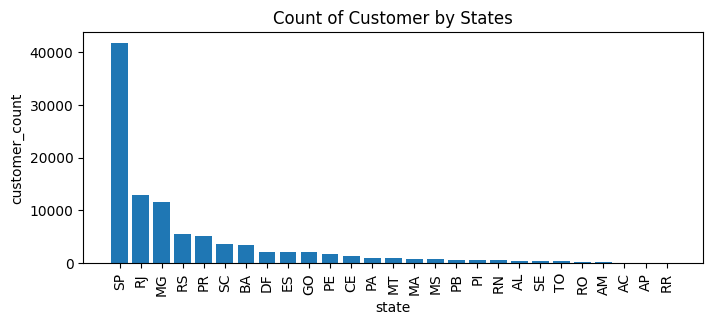

In [40]:
query = """ select customer_state, count(customer_id) from customers group by customer_state """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["State", "Customer_count"])
df = df.sort_values(by = "Customer_count", ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["State"], df["Customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("state")
plt.ylabel("customer_count")
plt.title("Count of Customer by States")
plt.show()

# Calculate the number of orders per month in 2018.

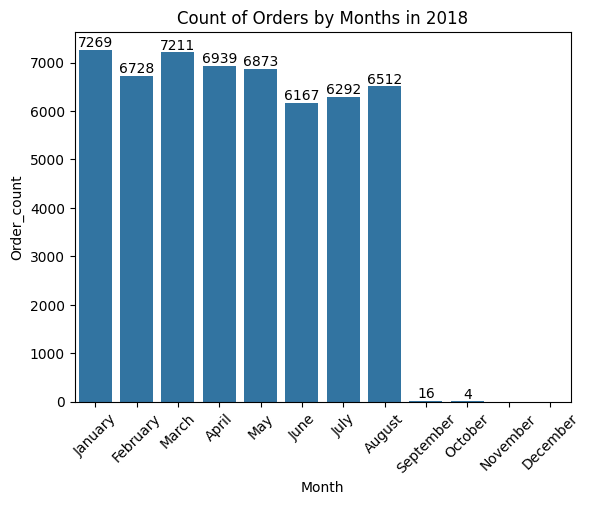

In [46]:
query = """ select monthname(order_purchase_timestamp), count(order_id)
            from orders
            where year(order_purchase_timestamp)  = 2018
            group by 1
            order by 2 desc """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Month", "Order_count"])
o = ["January" , "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

ax = sns.barplot(x = df["Month"], y = df["Order_count"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [50]:
query = """ with products_count as (select orders.order_id, orders.customer_id, count(order_items.order_item_id) products_count
            from orders
            join order_items
            on orders.order_id = order_items.order_id
            group by orders.order_id, orders.customer_id)
            select customers.customer_city, round(avg(products_count.products_count),2) avrage_products
            from customers
            join products_count
            on customers.customer_id = products_count.customer_id
            group by customers.customer_city """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_city", "products_count"])
df.head()

,customer_city,products_count
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27


# Calculate the percentage of total revenue contributed by each product category.

In [54]:
query = """ select upper(products.product_category) category, round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100, 2) revenue
            from products
            join order_items on products.product_id = order_items.product_id
            join payments on order_items.order_id = payments.order_id
            group by 1
            order by 2 desc """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["product_category", "percentage_of_revenue"])
df.head()

,product_category,percentage_of_revenue
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query = """ select upper(products.product_category),
    		count(order_items.product_id) as number_of_products,
            round(avg(order_items.price),2) as product_price
            from products
            join order_items on products.product_id = order_items.product_id
            group by products.product_category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["product_category", "order_count", "product_price"])
df.head()
arr1 = df["order_count"]
arr2 = df["product_price"]

a = np.corrcoef([arr1, arr2])
print("The correlation between product price and the number of times a product has been purchased is",a[0][1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

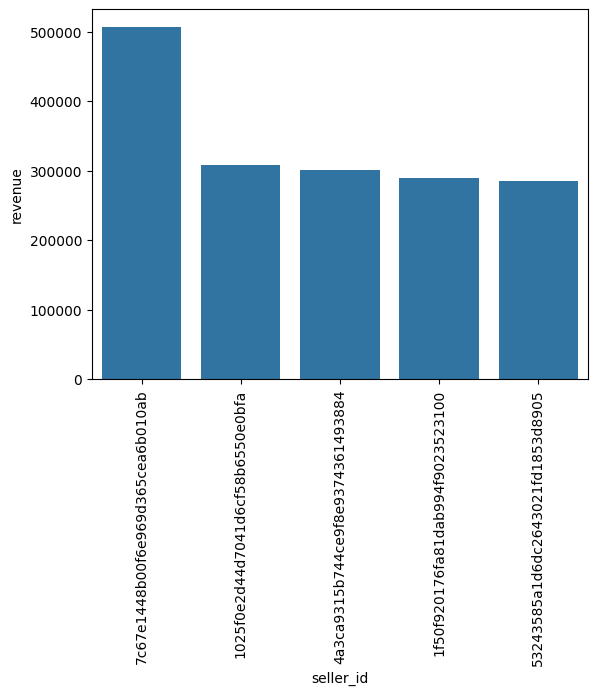

In [15]:
query = """ select *, rank() over(order by revenue desc) as rn
            from (select order_items.seller_id, round(sum(payments.payment_value),2) as revenue
                    from order_items
                    join payments on order_items.order_id = payments.order_id
                    group by order_items.seller_id) as a """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
sns.barplot(x = "seller_id", y = "revenue", data = df.head())
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [17]:
query = """ select customer_id, order_purchase_timestamp, payment_value, avg(payment_value) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as payment
            from (select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value
            from orders
            join payments on orders.order_id = payments.order_id) as a """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "payment","average payment"])

df.head()

,customer_id,order_purchase_timestamp,payment,average payment
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.

In [18]:
query = """ select *, sum(payment) over(order by years, months) as cumulative_sales
            from (select year(orders.order_purchase_timestamp) as years, month(order_purchase_timestamp) as months, round(sum(payments.payment_value), 2) as payment
                    from orders
                    join payments on orders.order_id = payments.order_id
                    group by years, months order by years, months) as a; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years", "months", "payment","cumulative_sales"])

df.head()

,years,months,payment,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# Calculate the year-over-year growth rate of total sales.

In [20]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years, round(sum(payments.payment_value), 2) as payment
                        from orders
                        join payments on orders.order_id = payments.order_id
                        group by years order by years)
            select years, payment, ((payment - lag(payment) over(order by years))/lag(payment) over(order by years))*100 as growth
            from a """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years", "payment", "yoy % growth"])

df.head()

,years,payment,yoy % growth
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [ ]:
query = """ with a as (select customers.customer_id,
                		min(orders.order_purchase_timestamp) first_order
                        from customers
                        join orders
                        on customers.customer_id = orders.customer_id
                        group by customers.customer_id),
            b as (select a.customer_id, count(distinct orders.order_purchase_timestamp)
                    from a join orders
                    on orders.customer_id = a.customer_id
                    and orders.order_purchase_timestamp > first_order
                    and  orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
                    group by a.customer_id)
            select 100*(count(distinct b.customer_id)/count(distinct a.customer_id)) retention_rate
            from a left join b
            on a.customer_id = b.customer_id; """

cur.execute(query)

data = cur.fetchall()

data

print("Retention rate of customers is", data[0][0])

# Identify the top 3 customers who spent the most money in each year.

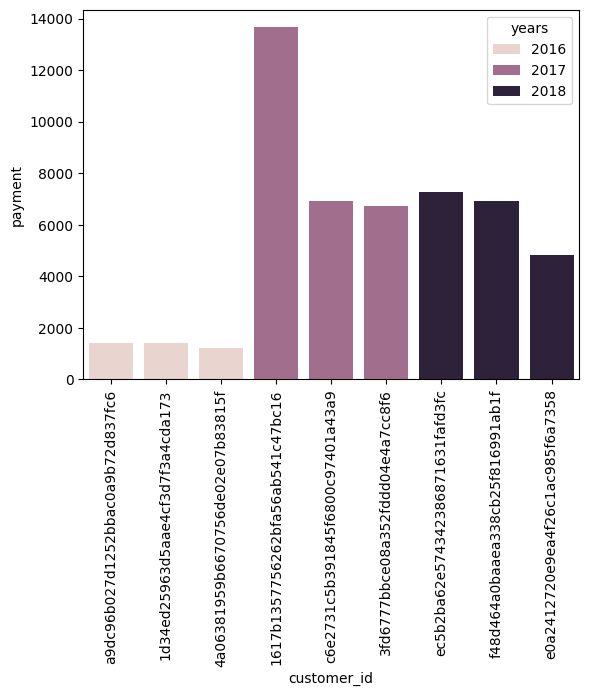

In [29]:
query = """ select * 
            from (select year(orders.order_purchase_timestamp)years,
            		orders.customer_id,
                    sum(payments.payment_value) payment,
                    dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as customer_rank
            		from orders
            		join payments on orders.order_id = payments.order_id
            		group by year(orders.order_purchase_timestamp),
            				orders.customer_id) as a
            where customer_rank <=3 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years", "customer_id", "payment", "rank"])

sns.barplot(x = "customer_id", y = "payment", data = df, hue = "years")

plt.xticks(rotation = 90)

plt.show()